In [1]:
import os

# os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
# os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [2]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import (
    fast_filter,
    loglikelihood_sysrem,
    get_rot_kernel,
    fit_uncertainties,
)
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import time

R_s = 1.458 * R_Sun  # Stellar radius (m)
T_s = 6776  # Stellar effective temperature (K)
Met_s = 0.13  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24  # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

F_s = star["F_star"]
wl_s = star["wl_star"]
R_s = star["R_s"]


# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

R_p = 1.753 * R_J  # Planetary radius (m)
M_p = 1.157 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.97 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2450  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# ***** Define model *****#

model_name = "Injection-retrieval-Fe-6"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["Cr"]  # H2O, CO as in Brogi & Line

# Create the model object
model = define_model(model_name, bulk_species, param_species, PT_profile="isotherm")

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))


# ***** Wavelength grid *****#

wl_min = 0.37  # Minimum wavelength (um)
wl_max = 0.51  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid

# wl = wl_grid_line_by_line(wl_min, wl_max)
wl = wl_grid_constant_R(wl_min, wl_max, R)

# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2000  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4000  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -12.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

# Specify the pressure grid of the atmosphere
P_min = 1e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-5  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

params = (-8, 3000)
log_Fe, T = params

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T])  # a1, a2, log_P1, log_P2, log_P3, T_deep
log_X_params = np.array([[log_Fe]])

atmosphere = make_atmosphere(
    planet,
    model,
    P,
    P_ref,
    R_p_ref,
    PT_params,
    log_X_params,
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="transmission"
)

Free parameters: ['R_p_ref' 'T' 'log_Cr']
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Cr done
Opacity pre-interpolation complete.


In [30]:
model = define_model(model_name, bulk_species, param_species, PT_profile="isotherm")
# Specify the pressure grid of the atmosphere
P_min = 1e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = 1.8 * R_J  # Radius at reference pressure

params = (-8, 2800)
log_Fe, T = params

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T])  # a1, a2, log_P1, log_P2, log_P3, T_deep
log_X_params = np.array([[log_Fe]])

atmosphere = make_atmosphere(
    planet,
    model,
    P,
    P_ref,
    R_p_ref,
    PT_params,
    log_X_params,
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="transmission"
)
# Create the model object
model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="isotherm",
    cloud_model="MacMad17",
    cloud_type="deck",
)

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

params = (-8, 2800)
log_Fe, T = params

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T])  # a1, a2, log_P1, log_P2, log_P3, T_deep
log_X_params = np.array([[log_Fe]])
cloud_params = np.array([np.log10(5e-2)])

atmosphere = make_atmosphere(
    planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params
)

# Generate planet surface flux
spectrum_cloudy = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="transmission"
)

Free parameters: ['R_p_ref' 'T' 'log_Cr' 'log_P_cloud']


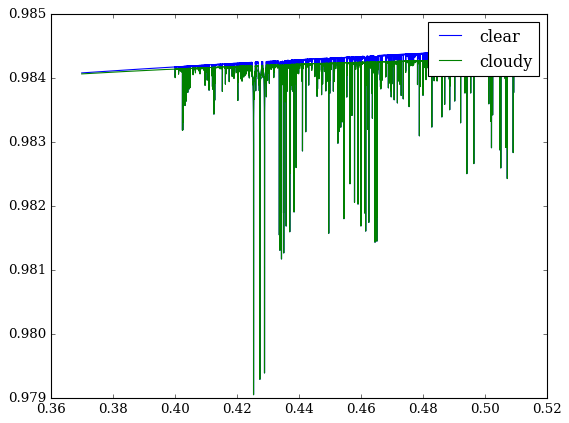

In [31]:
import matplotlib.pyplot as plt

plt.plot(wl, 1 - spectrum, label="clear")
plt.plot(wl, 1 - spectrum_cloudy, label="cloudy")
plt.legend()
# plt.xlim(0.39, 0.42)

In [35]:
0.118 * R_s / R_J

1.6741874727242207

In [3]:
# model_name = "Injection Retrieval Fe-6"  # Model name used for plots, output files etc.

# bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
# param_species = []  # H2O, CO as in Brogi & Line

# # Create the model object
# model = define_model(model_name, bulk_species, param_species, PT_profile="Madhu")

# # Check the free parameters defining this model
# print("Free parameters: " + str(model["param_names"]))

# params = (0.3, 0.3, -1, -2, 1, 3000)
# a1, a2, log_P1, log_P2, log_P3, T_ref = params

# # Provide a specific set of model parameters for the atmosphere
# PT_params = np.array(
#     [a1, a2, log_P1, log_P2, log_P3, T_ref]
# )  # a1, a2, log_P1, log_P2, log_P3, T_deep
# log_X_params = np.array([[log_Fe]])

# atmosphere = make_atmosphere(
#     planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, P_param_set=1
# )

# # Generate planet surface flux
# continuum_spectrum = compute_spectrum(
#     planet, star, model, atmosphere, opac, wl, spectrum_type="transmission"
# )

In [4]:
from POSEIDON.utility import read_high_res_data
from POSEIDON.high_res import fit_uncertainties
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import gaussian_filter1d, median_filter
from POSEIDON.high_res import fast_filter

output_name = "./data/WASP-121b-Fe-6.h5"


def make_injection_data(chip, wl, spectrum, K_p, V_sys):  # on which order
    f = h5py.File("./data/WASP-121b.h5", "r")
    flux = f["{}/flux".format(chip)][:]
    wl_grid = f["{}/wl_grid".format(chip)][:]
    phi = f["{}/phi".format(chip)][:]
    transit_weight = f["{}/transit_weight".format(chip)][:]
    f.close()

    RV_p = V_sys + K_p * np.sin(
        2 * np.pi * phi
    )  # V_sys is an additive term around zero
    dl_p = RV_p * 1e3 / constants.c  # delta lambda, for shifting
    N_order, N_phi, N_wl = flux.shape

    models_shifted = np.zeros(flux.shape)  # "shifted" model spectra array at each phase

    for i in range(N_order):
        for j in range(N_phi):
            wl_shifted_p = wl_grid[i] * (1.0 - dl_p[j])
            Fp = np.interp(wl_shifted_p, wl, spectrum)
            models_shifted[i][j] = ((1 - transit_weight[j])) / np.max(
                1 - transit_weight
            ) * (-Fp) + 1

    data_injected_raw = flux * models_shifted
    blaze = np.zeros(data_injected_raw.shape)
    for k in range(N_order):
        order = data_injected_raw[k]
        middle = np.median(order, axis=0)
        order_norm = order / middle
        blaze[k] = order_norm

    for det in range(N_order):
        for p in range(N_phi):
            blaze[det][p] = median_filter(blaze[det][p], size=501)

    for det in range(N_order):
        for p in range(N_phi):
            blaze[det][p] = gaussian_filter1d(blaze[det][p], sigma=100)

    data_blazed_corrected = data_injected_raw / blaze
    uncertainties = fit_uncertainties(
        data_blazed_corrected, NPC=5
    )  # add arguments for initial guess

    data_injected_blaze_corrected_norm = np.zeros_like(data_blazed_corrected)
    uncertainties_norm = np.zeros_like(uncertainties)
    for i in range(N_order):
        order = data_blazed_corrected[i]
        median = np.median(order, axis=0)
        order_norm = order / median

        uncertainty = uncertainties[i]
        uncertainty_norm = uncertainty / median

        uncertainties_norm[i] = uncertainty_norm
        data_injected_blaze_corrected_norm[i] = order_norm

    residuals, Us = fast_filter(
        data_injected_blaze_corrected_norm, uncertainties_norm, N_iter=15
    )
    Bs = np.zeros((N_order, N_phi, N_phi))

    for j in range(N_order):
        U = Us[j]
        L = np.diag(1 / np.mean(uncertainties[j], axis=-1))
        B = U @ np.linalg.pinv(L @ U) @ L
        Bs[j] = B

    new_f = h5py.File(output_name, "a")
    chip_group = new_f.create_group(chip)

    chip_group.create_dataset("flux", data=data_injected_raw)
    chip_group.create_dataset("flux_blaze_corrected", data=data_blazed_corrected)
    chip_group.create_dataset("wl_grid", data=wl_grid)
    chip_group.create_dataset("phi", data=phi)
    chip_group.create_dataset("transit_weight", data=transit_weight)
    chip_group.create_dataset("residuals", data=residuals)
    chip_group.create_dataset("Bs", data=Bs)
    chip_group.create_dataset("uncertainties", data=uncertainties_norm)
    new_f.close()

In [5]:
make_injection_data("redl", wl, spectrum, -200, -20)

3.2902938838893183 261.699079865417
2.9612117852757294 281.04717586254935
2.2542121231672025 302.885174200376
1.5374560420229044 347.5519658142751
1.0137377078220453 387.2669825278173
0.6731620002352332 422.2932195709591
0.40136470302142674 460.1815202900903
0.3566660756228865 471.09180225542394
0.2891918413330081 495.5139635171518
0.2762061633763473 503.24105485722174
0.33226081176800615 495.0024412903874
0.3158427313126617 498.2160336055756
0.3551376051156408 444.30213959801245
0.3320613811974076 428.6222036572556
0.35022614526382156 419.76494523945155
0.3723371539171417 407.3956337950274
0.37447944657070653 411.62919983381255
0.38329041756379556 404.0844979816086
0.3841436022133203 404.5532719771436
0.3844431121473586 407.3022255022238
0.38426728512753106 407.8154211378271
0.3747172267526414 414.6126258597891
0.3776276727364246 415.0262036681469
0.38633335438147637 409.49446526681544
0.37797767869589616 419.8898539191993
0.3945740977411595 425.75341438625765


In [6]:
make_injection_data("redu", wl, spectrum, -200, -20)

0.3882924065372467 897.4152412282388
0.3649707487537118 931.0464292482709
0.39492133690883957 858.4714194073456
0.40457856599662456 877.4968040853587
0.3833752259198969 907.2581869487187
0.39542745058890677 892.4899879770599
0.38651344371507135 867.220542340319
0.3923521376861141 864.1198983806275
0.5098191012065283 783.2081905786067
0.20154959021466154 1235.3457151248194
0.40014599277066376 988.4247272114308
0.38076838322457873 1057.0720936513571
0.39781099816353727 1005.2022374652732
0.3975212853799745 1029.819916426941
0.4055014886567787 1046.1251015847288
0.3594802046365646 1160.453343338138
0.35497013152268664 1026.2403218805173
0.3292491684984155 1058.970618266806
